# Beamforming Project 

## Problem Statement

Goal: **Implement, compare, and analyze** several classical and advanced acoustic beamforming algorithms on a controlled synthetic scene.  

---

## Scene Setup (Free-field, no flow)

- **Array Geometries**:
  1. **Uniform Circular Array (UCA):** 32 microphones, radius = 0.5 m  
  2. **Spiral (aperiodic):** 48 microphones, radius ≤ 0.6 m  

- **Sources (at z = 1.5 m):**
  - **S1:** (0.20, 0.00) m, tonal @ 2 kHz  
  - **S2:** (0.26, 0.00) m, tonal @ 2 kHz, **coherent with S1** (→ hard resolution test)  
  - **S3:** (−0.35, 0.25) m, broadband (1–4 kHz), **incoherent**  

- **Frequencies Evaluated:** 1, 2, 4, 8 kHz  
  - (8 kHz chosen to highlight **spatial aliasing** for the UCA)

- **Snapshots (Time Samples):**  
  Default: \(K = 200\)  
  Test with \(K \in \{25, 50, 100, 200\}\)

- **Noise:** Spatially white, **SNR = 10 dB (default)**

---

## Beamforming Algorithms to Implement

1. **Conventional Beamforming (CB)** – Delay and Sum  
2. **MVDR (Minimum Variance Distortionless Response)** – with diagonal loading  
3. **MUSIC** – eigenvalue decomposition method  
4. **Functional Beamforming (FB)** – parameter \(m\)  
5. **CLEAN-SC (simplified)** – deconvolution method  
6. **DAMAS** – Gauss–Seidel iterative solver, nonnegative constraint  

---

## Tasks

1. **Implement** all six algorithms.  
2. **Produce source maps** on a 2D scan grid.  
   - Compare across methods, arrays, frequencies, and snapshots.  
3. **Report performance metrics**:
   - Localization error  
   - Resolution (FWHM of mainlobe)  
   - MSR (Mainlobe-to-Sidelobe Ratio)  
   - False positives  
   - Runtime (computational cost)  
   - Robustness vs snapshots  
4. **Discussion**:
   - Effects of **spatial aliasing** (especially at 8 kHz)  
   - **Coherent source behavior** (S1 & S2 separation)  
   - **Array layout trade-offs** (UCA vs spiral)  
5. **(Bonus)**: Inject a **steering-vector mismatch** (e.g., +2% speed-of-sound error).  
   - Show which algorithms are more robust vs. sensitive.  

---

## Expected Deliverables

- Acoustic source maps (per method, frequency, snapshot, array type)  
- Quantitative performance metrics (tables/plots)  
- Comparative discussion on results  
- (Optional) Bonus analysis with steering-vector mismatch  

# 1. Conventional Beamforming - Delay-and-Sum (DAS)

1. Define the scene (speed of sound, sources, arrays, imaging grid).
2. Define the steering-vector function $g(\mathbf{x})$.
3. Define a frequency-domain cross-spectral matrix (CSM) for the sources + noise.
4. Implement DAS: $B(\mathbf{x}) = w^HCw$ with $w = g / ||g||$.
5. Plot and interpret results.
6. Evaluate metrics: peak, localization error, MSR.
7. Compare arrays & frequencies.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit sharper
plt.rcParams["figure.dpi"] = 140

# Physics
c = 343.0          # speed of sound [m/s]
z_plane = 1.5      # imaging plane z [m]

# Reproducibility for any randomness (noise, etc.)
rng = np.random.default_rng(42)

## Define the synthetic scene

* Two coherent tonal sources at 2 kHz (hard-resolution test).
* One broadband incoherent source (1–4 kHz).
* Two array geometries: UCA (circular) and aperiodic spiral.

In [36]:
# Step 1: Scene definition

# Sources (x, y) located on the imaging plane z = z_plane
sources = [
    {"name": "S1", "xy": ( 0.20,  0.00), "type": "tonal",     "f0": 2000.0,     "power": 1.0},
    {"name": "S2", "xy": ( 0.26,  0.00), "type": "tonal",     "f0": 2000.0,     "power": 1.0},
    {"name": "S3", "xy": (-0.35,  0.25), "type": "broadband", "band": (1e3, 4e3),"power": 0.7},
]
rho_S1S2 = 1.0  # coherence between S1 and S2 (1.0 = fully coherent)

# Arrays
def array_uca(num_mics=32, radius=0.5):
    """Uniform Circular Array on z=0."""
    ang = np.linspace(0, 2*np.pi, num_mics, endpoint=False)
    x = radius*np.cos(ang)
    y = radius*np.sin(ang)
    z = np.zeros_like(x)
    return np.vstack([x, y, z]).T

def array_spiral(num_mics=48, max_radius=0.6):
    """Aperiodic (Fermat) spiral to suppress sidelobes."""
    ga = np.pi * (3 - np.sqrt(5))  # golden angle
    n = np.arange(num_mics)
    r = max_radius * np.sqrt((n + 0.5)/num_mics)
    th = n * ga
    x = r*np.cos(th); y = r*np.sin(th); z = np.zeros_like(x)
    return np.vstack([x, y, z]).T

uca    = array_uca(32, 0.5)
spiral = array_spiral(48, 0.6)

# Imaging grid (x-y plane at z=z_plane)
grid_x = np.linspace(-0.7, 0.7, 141)
grid_y = np.linspace(-0.7, 0.7, 141)

# Frequencies to evaluate
freqs = [1000, 2000, 4000, 8000]  # Hz

# Noise level (spatially white)
SNR_dB_default = 10.0


#### Why these choices?

* The coherent pair (S1,S2) at 2 kHz stresses resolution limits.
* 8 kHz stresses spatial aliasing, especially on the circular array, since mic spacing becomes comparable to half-wavelength.

# Define the steering vector $\mathbf{g}$ (Green's function)

We assume spherical spreading and a phase delay:

$$
g_m(\mathbf{x}) = \frac{e^{-jkr_m}}{4\pi r_m}, \quad r_m = \|\mathbf{x}-\mathbf{x}_m\|, \quad k = 2\pi f/c.
$$

In [34]:
# Step 2: Steering vector / Green's function

def steering_vector(freq, mic_xyz, grid_xy, z_plane=1.5, c=343.0, decay=True):
    """
    Free-field monopole Green's function from a candidate source point (grid_xy, z_plane)
    to each microphone.
    Returns g in shape (M,), M = number of microphones.
    """
    k = 2*np.pi*freq / c
    xg, yg = grid_xy
    grid_xyz = np.array([xg, yg, z_plane])
    r = np.linalg.norm(mic_xyz - grid_xyz, axis=1)  # distances mic <-> grid point
    phase = np.exp(-1j * k * r)
    # What does this decay variable do?
    if decay:
        g = phase / (4*np.pi * np.maximum(r, 1e-6))  # avoid 1/0
    else:
        g = phase
    return g


## Build the CSM $\mathbf{C}$ at a single frequency

The CSM aggregates source contributions plus noise:

$$
\mathbf{C} = \sum_k P_k\, \mathbf{g}_k \mathbf{g}_k^\mathrm{H} \;+\; \text{(cross-terms for coherence)} \;+\; \sigma_n^2 \mathbf{I}.
$$

* For S1 & S2 (tonal), add **cross-terms** to model coherence.
* For S3 (broadband), add power only if the frequency lies in its band.
* Add white noise to reach a target SNR relative to total signal power.

In [32]:
# Step 3: Synthetic CSM (per frequency)

def synth_csm(freq, mic_xyz, sources, SNR_dB=10.0, rho12=1.0, z_plane=1.5, c=343.0):
    """
    Construct a model CSM at 'freq' for the given array and source set.
    - S1/S2 (tonal): includes cross-terms controlled by rho12 to emulate coherence.
    - Broadband sources: contribute only if 'freq' lies in their band.
    - Noise: spatially white, level chosen to achieve SNR_dB wrt signal power.
    """
    M = mic_xyz.shape[0]
    C = np.zeros((M, M), dtype=complex)

    # Tonal steering vectors for S1 and S2 (only if freq == f0)
    s1 = next(s for s in sources if s["name"] == "S1")
    s2 = next(s for s in sources if s["name"] == "S2")

    # Why did you define your steering vector like this?
    gS1 = steering_vector(freq, mic_xyz, s1["xy"], z_plane, c, True) if (s1["type"]=="tonal" and np.isclose(freq, s1["f0"])) else None
    gS2 = steering_vector(freq, mic_xyz, s2["xy"], z_plane, c, True) if (s2["type"]=="tonal" and np.isclose(freq, s2["f0"])) else None

    # Auto terms
    if gS1 is not None: C += s1["power"] * np.outer(gS1, gS1.conj()) # What is this outer() function?
    if gS2 is not None: C += s2["power"] * np.outer(gS2, gS2.conj()) # What is this conj() function?

    # Coherent cross-terms
    if (gS1 is not None) and (gS2 is not None) and (rho12 is not None):
        cross = rho12 * np.sqrt(s1["power"]*s2["power"])
        C += cross * np.outer(gS1, gS2.conj())
        C += cross.conjugate() * np.outer(gS2, gS1.conj()) # What is the difference between conj() and conjugate()?

    # Broadband sources
    for s in sources:
        if s["type"] == "broadband":
            fmin, fmax = s["band"]
            if fmin <= freq <= fmax:
                gb = steering_vector(freq, mic_xyz, s["xy"], z_plane, c, True)
                C += s["power"] * np.outer(gb, gb.conj())

    # White noise level to hit target SNR wrt average signal power per mic
    sig_pow = float(np.real(np.trace(C)) / M) if np.real(np.trace(C)) > 0 else 1e-12
    SNR_lin = 10.0**(SNR_dB/10.0)
    noise_pow = sig_pow / SNR_lin
    C += noise_pow * np.eye(M)

    return C


## DAS beamforming map

For each grid point:

1. Build $\mathbf{g}$,
2. Normalize $\mathbf{w} = \mathbf{g}/\|\mathbf{g}\|$ (prevents bias to nearer points),
3. Compute power $B = \mathbf{w}^\mathrm{H} \mathbf{C} \mathbf{w}$.

In [39]:
# Step 4: DAS map computation 

def das_map(freq, mic_xyz, C, grid_x, grid_y, z_plane=1.5, c=343.0):
    """
    DAS (Conventional) map: B(x) = w^H C w with w = g / ||g||.
    Returns a 2D array (ny, nx) aligned with (grid_y, grid_x).
    """
    nx, ny = len(grid_x), len(grid_y)
    B = np.zeros((ny, nx), dtype=float)
    for iy, gy in enumerate(grid_y):
        for ix, gx in enumerate(grid_x):
            g = steering_vector(freq, mic_xyz, (gx, gy), z_plane, c, True)
            norm = np.linalg.norm(g)
            w = g if norm < 1e-12 else g / norm
            B[iy, ix] = np.real((w.conj().T @ (C @ w)))
    return B


## Visualize a first map (UCA, 2 kHz)

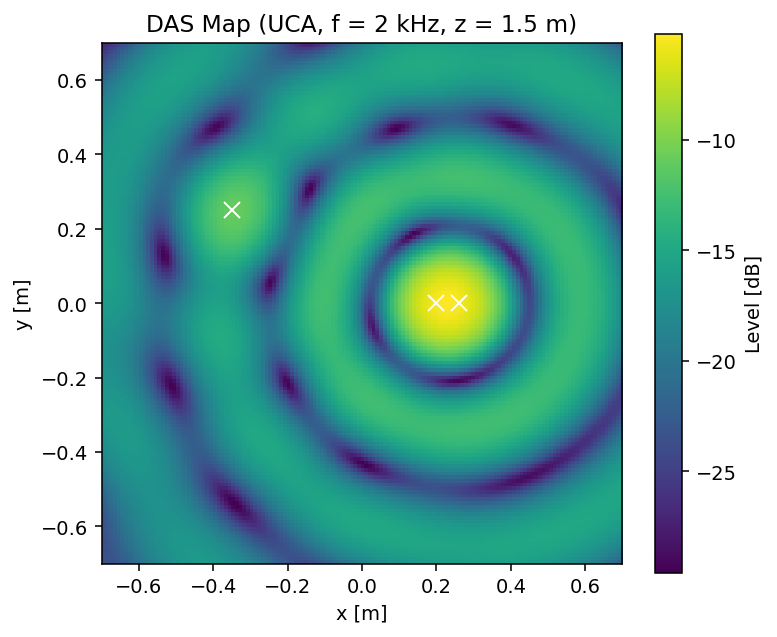

In [42]:
# Step 5: Run a demo (UCA, 2 kHz) 
freq = 2000
C_uca = synth_csm(freq, uca, sources, SNR_dB=SNR_dB_default, rho12=rho_S1S2, z_plane=z_plane, c=c)
B_uca = das_map(freq, uca, C_uca, grid_x, grid_y, z_plane=z_plane, c=c)

# Plot in dB
plt.figure(figsize=(6,5))
plt.imshow(10*np.log10(np.maximum(B_uca, 1e-16)),
           extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
           origin="lower", aspect="equal")
plt.colorbar(label="Level [dB]")
plt.title("DAS Map (UCA, f = 2 kHz, z = 1.5 m)")
plt.xlabel("x [m]"); plt.ylabel("y [m]")

# Mark true sources
for s in sources:
    plt.plot(s["xy"][0], s["xy"][1], "wx", ms=8)
plt.show()


**Interpretation:**

* we see a strong mainlobe near $x \approx 0.2$ to $0.26$ (coherent pair can blur/merge).
* we also see S3 (broadband) around $(-0.35, 0.25)$ at 2 kHz (within its 1–4 kHz band).
* Ringing around lobes are sidelobes (PSF of the array).

## Quick comparison: Circular & spiral array

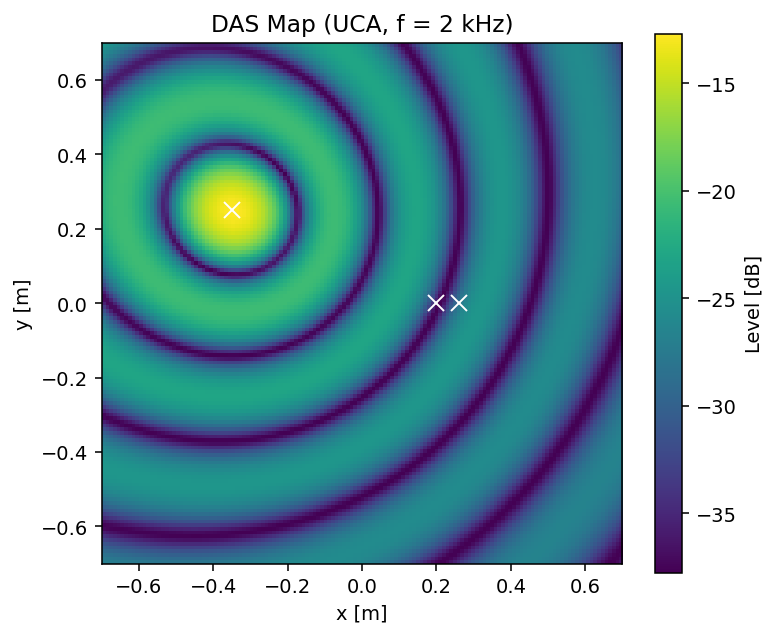

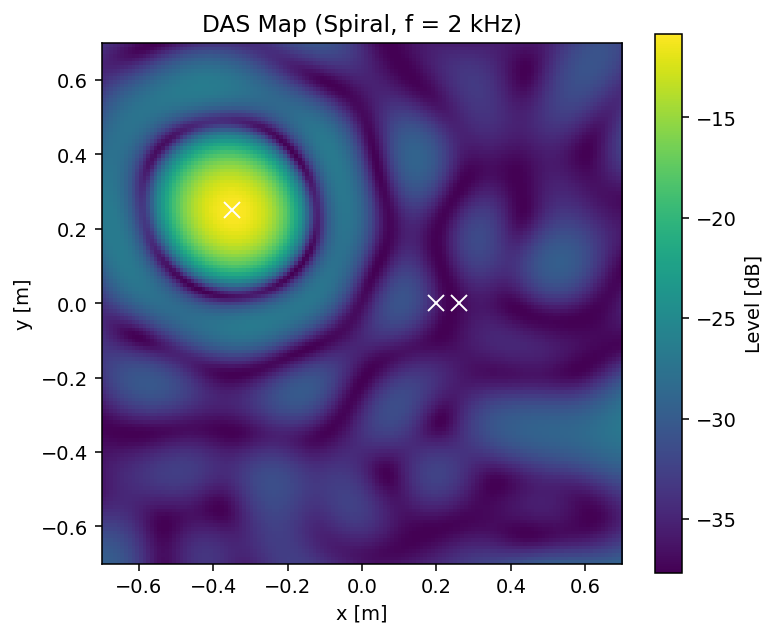

In [73]:
freq_hi = 2500
C_uca_hi = synth_csm(freq_hi, uca, sources, SNR_dB=SNR_dB_default, rho12=rho_S1S2, z_plane=z_plane, c=c)
B_uca_hi = das_map(freq_hi, uca, C_uca_hi, grid_x, grid_y, z_plane=z_plane, c=c)

plt.figure(figsize=(6,5))
plt.imshow(10*np.log10(np.maximum(B_uca_hi, 1e-16)),
           extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
           origin="lower", aspect="equal")
plt.colorbar(label="Level [dB]")
plt.title("DAS Map (UCA, f = 2 kHz)")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
for s in sources:
    plt.plot(s["xy"][0], s["xy"][1], "wx", ms=8)
plt.show()

# Spiral at 2 kHz (generally nicer sidelobes)
C_sp_2k = synth_csm(freq_hi, spiral, sources, SNR_dB=SNR_dB_default, rho12=rho_S1S2, z_plane=z_plane, c=c)
B_sp_2k = das_map(freq_hi, spiral, C_sp_2k, grid_x, grid_y, z_plane=z_plane, c=c)

plt.figure(figsize=(6,5))
plt.imshow(10*np.log10(np.maximum(B_sp_2k, 1e-16)),
           extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
           origin="lower", aspect="equal")
plt.colorbar(label="Level [dB]")
plt.title("DAS Map (Spiral, f = 2 kHz)")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
for s in sources:
    plt.plot(s["xy"][0], s["xy"][1], "wx", ms=8)
plt.show()


## Spiral array reduces regular grating lobes → cleaner maps than UCA with same aperture.

## Useful metrics (peak, localization error, FWHM, MSR)

These help quantify performance beyond just eyeballing maps.

In [56]:
# Step 6: Metrics utilities 

def find_map_peak(B, grid_x, grid_y):
    """Return peak value and its (x,y) coordinate."""
    iy, ix = np.unravel_index(np.argmax(B), B.shape)
    return float(B[iy, ix]), (grid_x[ix], grid_y[iy])

def nearest_true_sources_at_freq(freq, sources):
    """Return list of ground-truth source positions active at this freq."""
    xy_list = []
    for s in sources:
        if s["type"] == "tonal" and np.isclose(freq, s["f0"]):
            xy_list.append(s["xy"])
        if s["type"] == "broadband":
            fmin, fmax = s["band"]
            if fmin <= freq <= fmax:
                xy_list.append(s["xy"])
    return xy_list

def localization_error(peak_xy, freq, sources):
    """Euclidean distance to the nearest *active* true source at this frequency."""
    actives = nearest_true_sources_at_freq(freq, sources)
    if not actives:
        return np.nan
    dists = [np.hypot(peak_xy[0]-x, peak_xy[1]-y) for (x,y) in actives]
    return float(np.min(dists))

def estimate_fwhm(B, grid_x, grid_y, peak_xy):
    """
    Rough FWHM estimate: width at half-max on a horizontal and vertical
    cut through the peak; return average of the two.
    """
    # Locate nearest grid indices
    ix = int(np.argmin(np.abs(grid_x - peak_xy[0])))
    iy = int(np.argmin(np.abs(grid_y - peak_xy[1])))
    peak = B[iy, ix]
    half = 0.5*peak

    # Horizontal cut (y fixed)
    row = B[iy, :]
    left  = ix - np.argmax(row[:ix][::-1] < half) if np.any(row[:ix] < half) else 0
    right = ix + np.argmax(row[ix:]     < half)   if np.any(row[ix:]  < half) else len(grid_x)-1
    fwhm_x = grid_x[right] - grid_x[left]

    # Vertical cut (x fixed)
    col = B[:, ix]
    down = iy - np.argmax(col[:iy][::-1] < half) if np.any(col[:iy] < half) else 0
    up   = iy + np.argmax(col[iy:]       < half) if np.any(col[iy:] < half) else len(grid_y)-1
    fwhm_y = grid_y[up] - grid_y[down]

    return float((abs(fwhm_x)+abs(fwhm_y))/2)

def mainlobe_sidelobe_ratio(B, peak_xy, grid_x, grid_y, exclude_radius=0.08):
    """
    MSR (in dB): 10*log10(P_main / P_max_sidelobe).
    We exclude a small disk around the peak to search for the highest sidelobe.
    """
    # Build coordinate grids
    X, Y = np.meshgrid(grid_x, grid_y)
    # Mask mainlobe neighborhood
    mask = ( (X-peak_xy[0])**2 + (Y-peak_xy[1])**2 ) <= exclude_radius**2
    Bl = B.copy()
    Bl[mask] = -np.inf  # remove mainlobe neighborhood
    side_max = np.max(Bl)
    peak_val = B[np.argmin(np.abs(grid_y-peak_xy[1])), np.argmin(np.abs(grid_x-peak_xy[0]))]
    return 10*np.log10(peak_val / max(side_max, 1e-16))


### Use them on a map:

In [59]:
# Example on the UCA 2 kHz map
peak_val, peak_xy = find_map_peak(B_uca, grid_x, grid_y)
err = localization_error(peak_xy, 2000, sources)
fwhm = estimate_fwhm(B_uca, grid_x, grid_y, peak_xy)
msr_db = mainlobe_sidelobe_ratio(B_uca, peak_xy, grid_x, grid_y, exclude_radius=0.08)

print(f"Peak at {peak_xy}, value={peak_val:.3e}")
print(f"Localization error to nearest active source: {err:.3f} m")
print(f"FWHM (avg of x/y cuts): {fwhm:.3f} m")
print(f"Mainlobe-to-Sidelobe Ratio (MSR): {msr_db:.1f} dB")


Peak at (0.2300000000000001, 1.1102230246251565e-16), value=3.013e-01
Localization error to nearest active source: 0.030 m
FWHM (avg of x/y cuts): 0.200 m
Mainlobe-to-Sidelobe Ratio (MSR): 1.8 dB


## Batch runner (compare arrays & frequencies)

In [62]:
# Step 7: Batch evaluation helper 

def run_das_once(freq, mic_xyz, label):
    C = synth_csm(freq, mic_xyz, sources, SNR_dB=SNR_dB_default, rho12=rho_S1S2, z_plane=z_plane, c=c)
    B = das_map(freq, mic_xyz, C, grid_x, grid_y, z_plane=z_plane, c=c)
    peak_val, peak_xy = find_map_peak(B, grid_x, grid_y)
    metrics = {
        "array": label,
        "freq": freq,
        "peak_xy": peak_xy,
        "loc_error_m": localization_error(peak_xy, freq, sources),
        "fwhm_m": estimate_fwhm(B, grid_x, grid_y, peak_xy),
        "msr_db": mainlobe_sidelobe_ratio(B, peak_xy, grid_x, grid_y, exclude_radius=0.08),
    }
    return B, metrics

results = []
maps = []

for arr_label, arr in [("UCA", uca), ("Spiral", spiral)]:
    for f in freqs:
        B, m = run_das_once(f, arr, arr_label)
        maps.append((arr_label, f, B))
        results.append(m)

# Show a small summary
import pandas as pd
df = pd.DataFrame(results)
df


,array,freq,peak_xy,loc_error_m,fwhm_m,msr_db
0,UCA,1000,"(-0.3499999999999999, 0.2500000000000001)",1.241267e-16,0.425,0.377386
1,UCA,2000,"(0.2300000000000001, 1.1102230246251565e-16)",3.000000e-02,0.200,1.839329
2,UCA,4000,"(-0.3499999999999999, 0.2500000000000001)",1.241267e-16,0.110,7.431672
3,UCA,8000,"(-0.6399999999999999, -0.06999999999999995)",NaN,1.400,0.000000
4,Spiral,1000,"(-0.3499999999999999, 0.2500000000000001)",1.241267e-16,0.510,0.267663
5,Spiral,2000,"(0.2300000000000001, 1.1102230246251565e-16)",3.000000e-02,0.235,1.287211
6,Spiral,4000,"(-0.3499999999999999, 0.2500000000000001)",1.241267e-16,0.130,4.686734
7,Spiral,8000,"(0.44000000000000017, -0.52)",NaN,1.400,0.000000


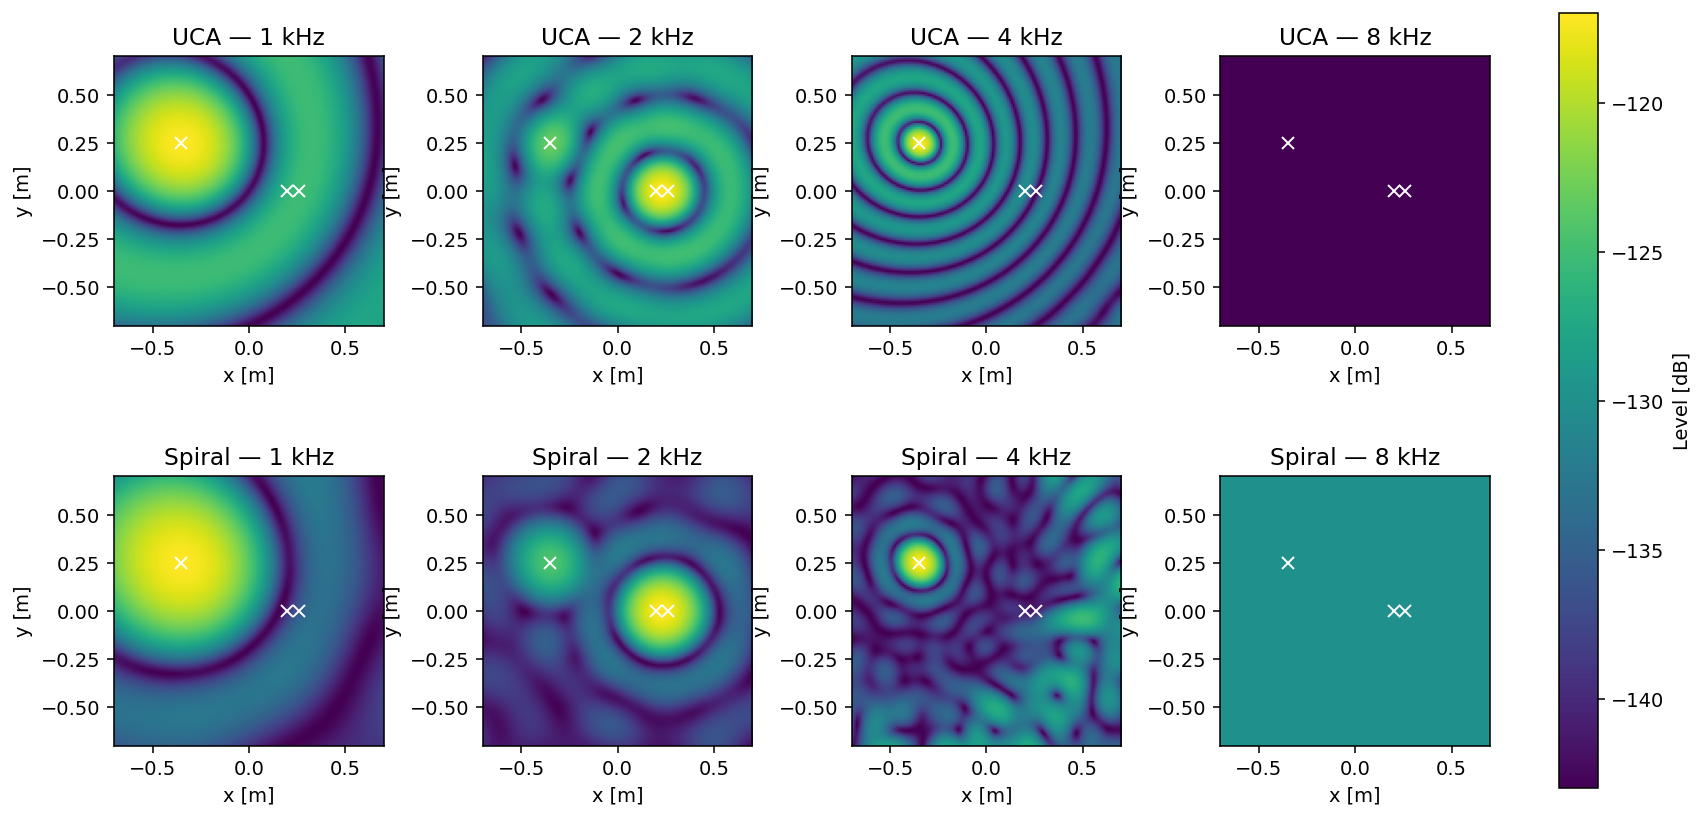

In [64]:
# Visualize a grid of maps 
ncols = len(freqs)
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows), constrained_layout=True)
for (arr_label, f, B), ax in zip(maps, axes.ravel()):
    im = ax.imshow(10*np.log10(np.maximum(B, 1e-16)),
                   extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
                   origin="lower", aspect="equal")
    ax.set_title(f"{arr_label} — {f/1000:g} kHz")
    ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]")
    for s in sources: ax.plot(s["xy"][0], s["xy"][1], "wx", ms=6)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95, label="Level [dB]")
plt.show()


## Key Points:

* **Steering vectors** model propagation; normalizing them avoids bias.
* The **CSM** embeds both power and **coherence** structure between microphones; DAS simply "looks" in a direction (or point) via $\mathbf{w}$.
* **Resolution** (FWHM) improves with **aperture** and **frequency**, but high frequency risks **aliasing** if mic spacing is coarse—spiral arrays help here.
* **Coherent sources** S1/S2 are hard for DAS: it often merges them; advanced methods (MVDR, MUSIC, deconvolution) do better.